In [1]:
import sys
sys.path += ['..']

In [30]:
import requests
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from financial_ml.features.systematic_default import compute_structural_asset_values

In [10]:
fmp_api_key = '727c2252a6128a8f37ab5d7058a6611f'

In [11]:
ticker = 'AAPL'
api_base = 'https://financialmodelingprep.com/api'
balance_sheet_api = f'{api_base}/v3/balance-sheet-statement/{ticker}?period=quarter&limit=120&apikey={fmp_api_key}'

In [12]:
balance_sheets = requests.get(balance_sheet_api).json()

In [13]:
balance_sheets_df = pd.DataFrame(balance_sheets)
balance_sheets_df = balance_sheets_df[['acceptedDate', 'shortTermDebt', 'longTermDebt']]
balance_sheets_df['acceptedDate'] = pd.to_datetime(balance_sheets_df['acceptedDate'])
balance_sheets_df = balance_sheets_df.sort_values('acceptedDate')
balance_sheets_df

,acceptedDate,shortTermDebt,longTermDebt
119,1993-06-30 00:00:00,308200000,0
118,1993-09-30 00:00:00,823200000,0
117,1994-01-26 00:00:00,752257000,0
116,1994-03-31 00:00:00,490700000,304900000
115,1994-08-12 00:00:00,515608000,304815000
...,...,...,...
4,2022-04-28 18:03:58,16658000000,103323000000
3,2022-07-28 18:06:56,24991000000,94700000000
2,2022-10-27 18:01:14,21110000000,98959000000
1,2023-02-02 18:01:30,11483000000,99627000000


In [14]:
market_cap_api = f'{api_base}/v3/historical-market-capitalization/{ticker}?limit=7700&apikey={fmp_api_key}'

In [15]:
market_caps = requests.get(market_cap_api).json()

In [16]:
market_caps = pd.DataFrame(market_caps)
market_caps = market_caps[['date', 'marketCap']]
market_caps['date'] = pd.to_datetime(market_caps['date'])
market_caps = market_caps.sort_values('date').reset_index(drop=True)
market_caps

,date,marketCap
0,1992-11-25,6845310123
1,1992-11-27,6845310123
2,1992-11-30,6966471938
3,1992-12-01,7057333123
4,1992-12-02,6936184876
...,...,...
7695,2023-06-20,2920781361540
7696,2023-06-21,2904204849840
7697,2023-06-22,2952197798000
7698,2023-06-23,2947145908720


In [17]:
join_indices = market_caps['date'].apply(lambda d: balance_sheets_df['acceptedDate'].searchsorted(d) - 1).values
balance_sheets_join = balance_sheets_df.iloc[join_indices].copy()
balance_sheets_join['acceptedDate'] = balance_sheets_join['acceptedDate'].where(join_indices >= 0)
balance_sheets_join = balance_sheets_join.reset_index(drop=True)
balance_sheets_join

,acceptedDate,shortTermDebt,longTermDebt
0,NaT,12574000000,97041000000
1,NaT,12574000000,97041000000
2,NaT,12574000000,97041000000
3,NaT,12574000000,97041000000
4,NaT,12574000000,97041000000
...,...,...,...
7695,2023-05-04 18:03:52,12574000000,97041000000
7696,2023-05-04 18:03:52,12574000000,97041000000
7697,2023-05-04 18:03:52,12574000000,97041000000
7698,2023-05-04 18:03:52,12574000000,97041000000


In [18]:
dataset = pd.concat([market_caps, balance_sheets_join], axis=1)
dataset = dataset.dropna(subset='acceptedDate')
dataset

,date,marketCap,acceptedDate,shortTermDebt,longTermDebt
150,1993-07-01,4526753812,1993-06-30 00:00:00,308200000,0
151,1993-07-02,4586312500,1993-06-30 00:00:00,308200000,0
152,1993-07-06,4496974468,1993-06-30 00:00:00,308200000,0
153,1993-07-07,4348064406,1993-06-30 00:00:00,308200000,0
154,1993-07-08,4348064406,1993-06-30 00:00:00,308200000,0
...,...,...,...,...,...
7695,2023-06-20,2920781361540,2023-05-04 18:03:52,12574000000,97041000000
7696,2023-06-21,2904204849840,2023-05-04 18:03:52,12574000000,97041000000
7697,2023-06-22,2952197798000,2023-05-04 18:03:52,12574000000,97041000000
7698,2023-06-23,2947145908720,2023-05-04 18:03:52,12574000000,97041000000


In [19]:
treasury_yields = pd.read_csv('../data/treasury_yield_1Y.csv')
treasury_yields['DATE'] = pd.to_datetime(treasury_yields['DATE'])
treasury_yields = treasury_yields.dropna(subset='DGS1')
treasury_yields = treasury_yields[treasury_yields['DGS1'] != '.']
treasury_yields['DGS1'] = treasury_yields['DGS1'].astype(float)/100

In [20]:
treasury_yields

,DATE,DGS1
0,1993-01-04,0.0356
1,1993-01-05,0.0358
2,1993-01-06,0.0362
3,1993-01-07,0.0370
4,1993-01-08,0.0356
...,...,...
7944,2023-06-16,0.0524
7946,2023-06-20,0.0524
7947,2023-06-21,0.0525
7948,2023-06-22,0.0529


In [21]:
dataset = dataset.merge(treasury_yields, left_on='date', right_on=['DATE'])
dataset = dataset.drop(columns=['DATE', 'acceptedDate']).rename(columns={'DGS1': 'treasury_yield'})
dataset = dataset.dropna(subset='treasury_yield')
dataset.to_csv('../data/aapl_structural_data.csv', index=False)

In [22]:
dataset = pd.read_csv('../data/aapl_structural_data.csv')
dataset['date'] = pd.to_datetime(dataset['date'])

In [23]:
dataset

,date,marketCap,shortTermDebt,longTermDebt,treasury_yield
0,1993-07-01,4526753812,308200000,0,0.0341
1,1993-07-02,4586312500,308200000,0,0.0334
2,1993-07-06,4496974468,308200000,0,0.0342
3,1993-07-07,4348064406,308200000,0,0.0343
4,1993-07-08,4348064406,308200000,0,0.0342
...,...,...,...,...,...
7484,2023-06-16,2919360517680,12574000000,97041000000,0.0524
7485,2023-06-20,2920781361540,12574000000,97041000000,0.0524
7486,2023-06-21,2904204849840,12574000000,97041000000,0.0525
7487,2023-06-22,2952197798000,12574000000,97041000000,0.0529


In [24]:
dataset_monthly = dataset.resample('MS', on='date').first()

In [25]:
dataset_monthly

,marketCap,shortTermDebt,longTermDebt,treasury_yield
date,,,,
1993-07-01,4526753812,308200000,0,0.0341
1993-08-01,3395058688,308200000,0,0.0358
1993-09-01,3112141578,308200000,0,0.0336
1993-10-01,2660763742,823200000,0,0.0335
1993-11-01,3684134412,823200000,0,0.0353
...,...,...,...,...
2023-02-01,2295925806220,21110000000,98959000000,0.0466
2023-03-01,2294031347740,11483000000,99627000000,0.0506
2023-04-01,2623351380180,11483000000,99627000000,0.0460


In [28]:
asset_values, asset_volatility = compute_structural_asset_values(
    equity_values=dataset_monthly['marketCap'].values,
    debt_values=(dataset_monthly['shortTermDebt'] + dataset_monthly['longTermDebt']/2).values,
    debt_maturities=[1]*len(dataset_monthly),
    data_interval=1/12,
    risk_free_rates=dataset_monthly['treasury_yield'],
)

<AxesSubplot: ylabel='marketCap'>

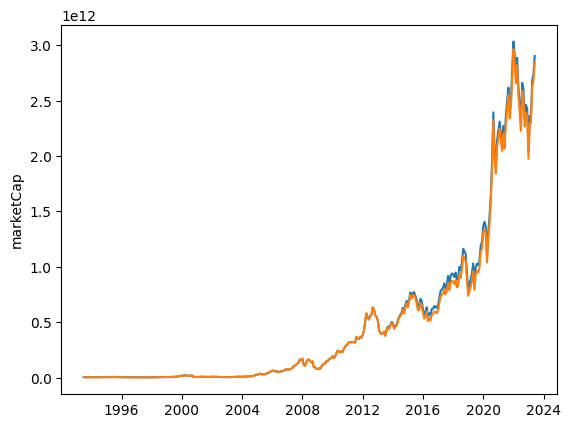

In [38]:
sns.lineplot(x=dataset_monthly.index.values, y=asset_values)
sns.lineplot(x=dataset_monthly.index.values, y=dataset_monthly['marketCap'])